In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1_limited",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 420,
    "seed": 420,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 628.3234, train_label_loss: 2.7965, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11610.1472, train_label_loss: 2.7123, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11687.8255, train_label_loss: 2.6793, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11559.5108, train_label_loss: 2.6953, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11589.0245, train_label_loss: 2.6111, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11688.3107, train_label_loss: 2.6393, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11583.9609, train_label_loss: 2.5778, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11691.9453, train_label_loss: 2.5934, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11553.4180, train_label_loss: 2.5178, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11642.5518, train_label_loss: 2.4621, 


epoch: 1, source_val_acc_label: 0.1845, source_val_label_loss: 2.4855, target_val_acc_label: 0.1845, target_val_label_loss: 2.4855, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 54.2581, train_label_loss: 2.4727, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11671.7731, train_label_loss: 2.5646, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11646.5875, train_label_loss: 2.3426, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11698.3563, train_label_loss: 2.2822, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11658.6534, train_label_loss: 2.3858, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11588.4259, train_label_loss: 2.2219, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11705.4105, train_label_loss: 2.2090, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11541.1098, train_label_loss: 2.1158, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11607.7598, train_label_loss: 2.0670, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11699.4416, train_label_loss: 2.0482, 


epoch: 2, source_val_acc_label: 0.3361, source_val_label_loss: 2.0000, target_val_acc_label: 0.3361, target_val_label_loss: 2.0000, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 63.6815, train_label_loss: 1.9406, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11631.6385, train_label_loss: 1.9257, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11584.7268, train_label_loss: 1.8524, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11483.2083, train_label_loss: 1.7991, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11741.0022, train_label_loss: 1.8137, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11702.6986, train_label_loss: 1.7289, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11666.7354, train_label_loss: 1.8605, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11673.2674, train_label_loss: 1.7232, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11696.6651, train_label_loss: 1.7473, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11749.6359, train_label_loss: 1.6441, 


epoch: 3, source_val_acc_label: 0.4260, source_val_label_loss: 1.6941, target_val_acc_label: 0.4260, target_val_label_loss: 1.6941, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 66.1602, train_label_loss: 1.4130, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 12425.5581, train_label_loss: 1.4336, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 12189.1020, train_label_loss: 1.5236, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 12413.7415, train_label_loss: 1.3730, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 12524.4705, train_label_loss: 1.9490, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 12586.1555, train_label_loss: 1.4022, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 12350.9864, train_label_loss: 1.7884, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11766.1403, train_label_loss: 1.5401, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 10731.1972, train_label_loss: 1.3960, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 10718.7768, train_label_loss: 1.5749, 


epoch: 4, source_val_acc_label: 0.4620, source_val_label_loss: 1.5266, target_val_acc_label: 0.4620, target_val_label_loss: 1.5266, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 55.9600, train_label_loss: 1.2829, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 10635.0812, train_label_loss: 1.1123, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 10683.7522, train_label_loss: 1.3849, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11401.5850, train_label_loss: 1.3506, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11810.4072, train_label_loss: 1.2850, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11802.5198, train_label_loss: 1.2405, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11693.0403, train_label_loss: 1.1367, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11754.2609, train_label_loss: 1.1018, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11715.7686, train_label_loss: 1.1971, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11768.0967, train_label_loss: 1.2129, 


epoch: 5, source_val_acc_label: 0.4811, source_val_label_loss: 1.4556, target_val_acc_label: 0.4811, target_val_label_loss: 1.4556, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 64.2325, train_label_loss: 1.1063, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 11725.8316, train_label_loss: 1.0413, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 11812.4397, train_label_loss: 0.7680, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 11767.8001, train_label_loss: 0.9965, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 11791.9135, train_label_loss: 0.8613, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 11751.5355, train_label_loss: 0.8079, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 11776.0582, train_label_loss: 0.9776, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11707.5055, train_label_loss: 1.2781, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 11715.4527, train_label_loss: 0.9143, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 11800.0480, train_label_loss: 0.9781, 


epoch: 6, source_val_acc_label: 0.4942, source_val_label_loss: 1.4415, target_val_acc_label: 0.4942, target_val_label_loss: 1.4415, 


New best
epoch: 7, [batch: 1 / 1400], examples_per_second: 63.7069, train_label_loss: 0.7799, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 11614.9557, train_label_loss: 0.6398, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 11823.2392, train_label_loss: 0.6055, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 11752.5792, train_label_loss: 0.6697, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 11763.9967, train_label_loss: 0.7473, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 11760.5141, train_label_loss: 0.7477, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 11811.5097, train_label_loss: 0.6833, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 11811.8679, train_label_loss: 0.6634, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 11846.2660, train_label_loss: 0.7280, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 11734.2293, train_label_loss: 0.9638, 


epoch: 7, source_val_acc_label: 0.4831, source_val_label_loss: 1.4948, target_val_acc_label: 0.4831, target_val_label_loss: 1.4948, 


epoch: 8, [batch: 1 / 1400], examples_per_second: 65.1949, train_label_loss: 0.4298, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 11780.7447, train_label_loss: 0.5608, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 11732.6504, train_label_loss: 0.6237, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 11711.4641, train_label_loss: 0.5726, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 11755.2683, train_label_loss: 0.4585, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 11718.9598, train_label_loss: 0.5895, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 11789.8862, train_label_loss: 0.5710, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 11784.1911, train_label_loss: 0.5387, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 11695.5640, train_label_loss: 0.6141, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 11700.9551, train_label_loss: 0.7969, 


epoch: 8, source_val_acc_label: 0.4758, source_val_label_loss: 1.6372, target_val_acc_label: 0.4758, target_val_label_loss: 1.6372, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 64.9056, train_label_loss: 0.7668, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 11714.0884, train_label_loss: 0.3508, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 12392.0223, train_label_loss: 0.5045, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 11804.1769, train_label_loss: 0.4413, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 11744.2604, train_label_loss: 0.4041, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 11685.1943, train_label_loss: 0.3428, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 11649.0478, train_label_loss: 0.8122, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 11692.2727, train_label_loss: 0.3750, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 11695.4511, train_label_loss: 0.4975, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 11719.3326, train_label_loss: 0.4778, 


epoch: 9, source_val_acc_label: 0.4749, source_val_label_loss: 1.6989, target_val_acc_label: 0.4749, target_val_label_loss: 1.6989, 


epoch: 10, [batch: 1 / 1400], examples_per_second: 65.1804, train_label_loss: 0.4120, 


epoch: 10, [batch: 140 / 1400], examples_per_second: 11665.0499, train_label_loss: 0.4523, 


epoch: 10, [batch: 280 / 1400], examples_per_second: 11760.5822, train_label_loss: 0.2526, 


epoch: 10, [batch: 420 / 1400], examples_per_second: 11690.1359, train_label_loss: 0.2736, 


epoch: 10, [batch: 560 / 1400], examples_per_second: 11594.6165, train_label_loss: 0.3251, 


epoch: 10, [batch: 700 / 1400], examples_per_second: 11694.7942, train_label_loss: 0.2464, 


epoch: 10, [batch: 840 / 1400], examples_per_second: 11625.6980, train_label_loss: 0.2865, 


epoch: 10, [batch: 980 / 1400], examples_per_second: 11754.4190, train_label_loss: 0.2781, 


epoch: 10, [batch: 1120 / 1400], examples_per_second: 11680.1498, train_label_loss: 0.3988, 


epoch: 10, [batch: 1260 / 1400], examples_per_second: 11754.6616, train_label_loss: 0.3910, 


epoch: 10, source_val_acc_label: 0.4725, source_val_label_loss: 1.7301, target_val_acc_label: 0.4725, target_val_label_loss: 1.7301, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

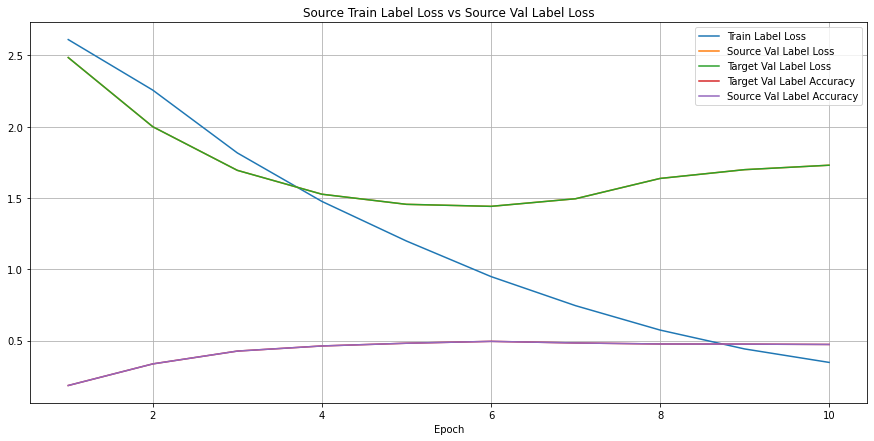

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

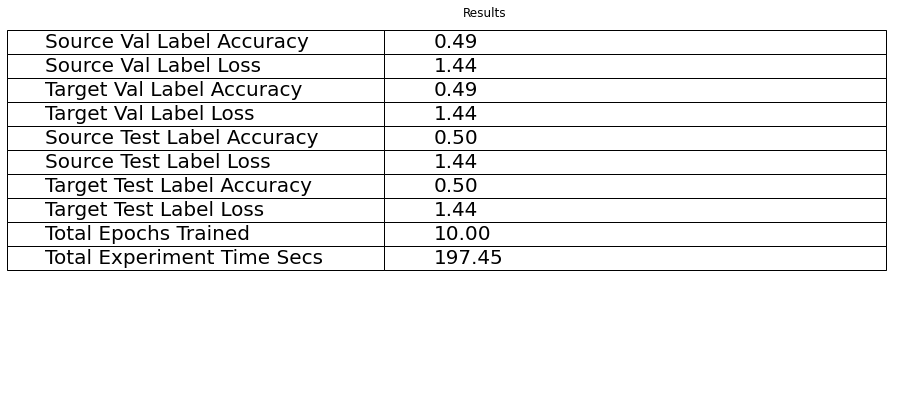

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

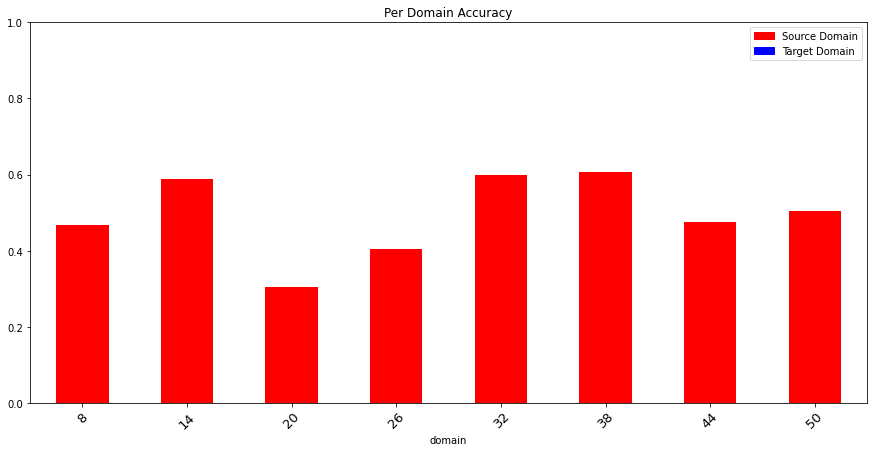

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.499921875 Target Test Label Accuracy: 0.499921875
Source Val Label Accuracy: 0.4942447916666667 Target Val Label Accuracy: 0.4942447916666667


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1_limited", "parameters": {"experiment_name": "cnn_2:oracle.run1_limited", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 2